# Unet


## Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract (batch) number of random images from the given image dataset. 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
        
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0    # if bigger than 2, black out. 
        mask[mask != 0 ] = 1   # make the rest 1.
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

## Breakdown

### batch
a selection of a (batch) number of images pulled out of the `all_files` of total 7390 images.

In [ ]:
# all image files in the 'images' folder
all_files = os.listdir('images')    # 7390 images
shuffle(all_files)

batch = np.random.choice(all_files, size = 32)  
print(batch)
print(len(batch))

['Russian_Blue_118.jpg' 'staffordshire_bull_terrier_202.jpg'
 'basset_hound_138.jpg' 'chihuahua_141.jpg' 'Persian_97.jpg'
 'scottish_terrier_161.jpg' 'great_pyrenees_32.jpg' 'Sphynx_33.jpg'
 'samoyed_199.jpg' 'keeshond_21.jpg' 'samoyed_191.jpg'
 'British_Shorthair_68.jpg' 'leonberger_5.jpg' 'japanese_chin_199.jpg'
 'Sphynx_14.jpg' 'great_pyrenees_63.jpg' 'Bombay_117.jpg'
 'wheaten_terrier_75.jpg' 'newfoundland_49.jpg' 'Maine_Coon_222.jpg'
 'basset_hound_168.jpg' 'Sphynx_206.jpg' 'chihuahua_34.jpg'
 'Russian_Blue_156.jpg' 'havanese_171.jpg' 'boxer_66.jpg'
 'yorkshire_terrier_16.jpg' 'japanese_chin_95.jpg' 'Egyptian_Mau_108.jpg'
 'Siamese_159.jpg' 'Abyssinian_96.jpg' 'chihuahua_5.jpg']
32


### mask

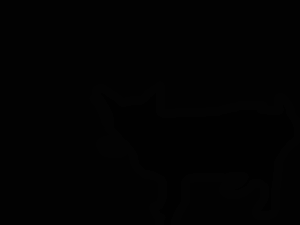

In [ ]:
mask = Image.open(f'annotations/trimaps/Abyssinian_201.png')
mask

#### Before processing mask

In [ ]:
flat_mask = mask.flatten()
print(len(flat_mask))           # vector count = 65536
print(np.unique(flat_mask))     # unique values = [1 2 3]

65536
[1 2 3]


In [ ]:
import pandas as pd
mask_df = pd.Series(flat_mask)
mask_df.value_counts()

2    48464
1    10248
3     6824
dtype: int64

In [ ]:
mask = np.array(mask.resize((256, 256)))

with np.printoptions(threshold=np.inf):
    print(mask)

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2

#### After processing mask - scaling

In [ ]:
import pandas as pd
mask_df1 = pd.Series(mask.flatten())
mask_df1.value_counts()

0    55288
1    10248
dtype: int64

In [ ]:
#preprocess the mask 
mask[mask >= 2] = 0    # if bigger than 2, black out. 
mask[mask != 0 ] = 1   # make the rest 1.

with np.printoptions(threshold=np.inf):
    print(mask)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
#variables for collecting batches of inputs and outputs 
batch_y = []

batch_y.append(mask)
batch_y

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

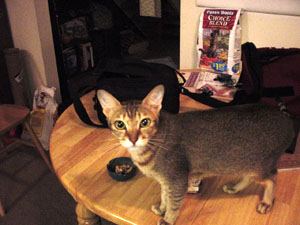

In [ ]:
Abyssinian_201 = Image.open(f'images/Abyssinian_201.jpg')
Abyssinian_201

In [ ]:
Abyssinian_201_array = np.asarray(Abyssinian_201)
Abyssinian_201_array

array([[[ 26,  14,  14],
        [ 22,  14,  12],
        [ 20,  16,  15],
        ...,
        [175, 153, 140],
        [171, 149, 136],
        [168, 146, 133]],

       [[ 26,  14,  14],
        [ 23,  14,  15],
        [ 21,  17,  16],
        ...,
        [183, 159, 147],
        [180, 156, 144],
        [179, 155, 143]],

       [[ 26,  14,  14],
        [ 24,  15,  16],
        [ 22,  18,  19],
        ...,
        [187, 159, 147],
        [185, 157, 145],
        [184, 156, 144]],

       ...,

       [[ 48,  40,  38],
        [ 49,  41,  39],
        [ 53,  43,  42],
        ...,
        [185, 108,  64],
        [190, 116,  71],
        [187, 116,  70]],

       [[ 52,  47,  44],
        [ 53,  48,  45],
        [ 58,  50,  48],
        ...,
        [187, 110,  66],
        [185, 112,  67],
        [181, 110,  64]],

       [[ 60,  42,  40],
        [ 59,  44,  41],
        [ 57,  46,  42],
        ...,
        [184, 111,  66],
        [188, 115,  70],
        [181,  96,  65]]

In [ ]:
Abyssinian_201_array.shape

(225, 300, 3)

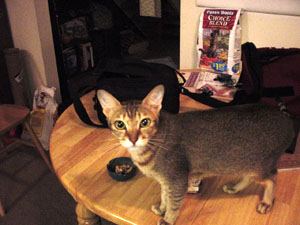

In [ ]:
#preprocess the raw images 
batch_x = []

raw = Image.open(f'images/Abyssinian_201.jpg')
raw

In [ ]:
sz = (256, 256)
raw = raw.resize(sz)
print(f"raw.resize(sz):\n{raw.resize(sz)}")

raw.resize(sz):
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9A4F06EC10>


In [ ]:
raw = np.array(raw)

with np.printoptions(threshold=np.inf):
    print(raw)

[[[ 26  14  14]
  [ 21  14  13]
  [ 19  17  16]
  [ 29  26  23]
  [ 64  53  48]
  [102  80  72]
  [111  82  73]
  [114  82  79]
  [119  85  76]
  [123  87  71]
  [126  89  70]
  [127  91  75]
  [127  96  85]
  [130  96  87]
  [139  94  83]
  [143 100  88]
  [140 100  86]
  [138 101  85]
  [140 104  85]
  [140 106  87]
  [141 104  83]
  [147 106  86]
  [149 107  94]
  [149 106  99]
  [147 104  96]
  [147 105  91]
  [147 105  84]
  [143 108  91]
  [139 104  92]
  [120  83  74]
  [121  82  76]
  [124  84  76]
  [126  85  72]
  [131  90  72]
  [120  88  81]
  [123  87  84]
  [129  87  85]
  [133  88  85]
  [129  85  80]
  [138  97  91]
  [104  66  60]
  [  8   7   3]
  [ 11   9   9]
  [  8   6  10]
  [  9   7  13]
  [ 18  16  20]
  [ 19  18  16]
  [  8   7   4]
  [ 13  11  14]
  [ 10   8  11]
  [  9   7  10]
  [  6   4   7]
  [  6   4   7]
  [  6   4   7]
  [  7   6   9]
  [  8   8  10]
  [  4   4   6]
  [  3   3   5]
  [  6   6   8]
  [  8   8  10]
  [  6   6   8]
  [  6   4   7]
  [  7  

In [ ]:
raw

array([[[ 26,  14,  14],
        [ 21,  14,  13],
        [ 19,  17,  16],
        ...,
        [176, 154, 142],
        [172, 150, 137],
        [168, 146, 133]],

       [[ 26,  14,  14],
        [ 22,  15,  15],
        [ 20,  18,  16],
        ...,
        [183, 159, 148],
        [179, 156, 144],
        [177, 154, 141]],

       [[ 26,  14,  14],
        [ 23,  16,  16],
        [ 20,  18,  18],
        ...,
        [186, 160, 148],
        [185, 158, 146],
        [183, 156, 144]],

       ...,

       [[ 49,  42,  40],
        [ 51,  43,  42],
        [ 56,  47,  46],
        ...,
        [183, 105,  60],
        [188, 113,  68],
        [186, 115,  68]],

       [[ 53,  47,  44],
        [ 55,  49,  46],
        [ 59,  50,  48],
        ...,
        [183, 106,  62],
        [186, 112,  67],
        [181, 108,  64]],

       [[ 60,  42,  40],
        [ 59,  45,  41],
        [ 56,  46,  41],
        ...,
        [183, 104,  66],
        [187, 115,  69],
        [182,  99,  66]]

In [ ]:
#check the number of channels because some of the images are RGBA or GRAY
if len(raw.shape) == 2:
    raw = np.stack((raw,)*3, axis=-1)

else:
    raw = raw[:,:,0:3]

batch_x.append(raw)
 
with np.printoptions(threshold=np.inf):
    print(raw)

[[[ 26  14  14]
  [ 21  14  13]
  [ 19  17  16]
  [ 29  26  23]
  [ 64  53  48]
  [102  80  72]
  [111  82  73]
  [114  82  79]
  [119  85  76]
  [123  87  71]
  [126  89  70]
  [127  91  75]
  [127  96  85]
  [130  96  87]
  [139  94  83]
  [143 100  88]
  [140 100  86]
  [138 101  85]
  [140 104  85]
  [140 106  87]
  [141 104  83]
  [147 106  86]
  [149 107  94]
  [149 106  99]
  [147 104  96]
  [147 105  91]
  [147 105  84]
  [143 108  91]
  [139 104  92]
  [120  83  74]
  [121  82  76]
  [124  84  76]
  [126  85  72]
  [131  90  72]
  [120  88  81]
  [123  87  84]
  [129  87  85]
  [133  88  85]
  [129  85  80]
  [138  97  91]
  [104  66  60]
  [  8   7   3]
  [ 11   9   9]
  [  8   6  10]
  [  9   7  13]
  [ 18  16  20]
  [ 19  18  16]
  [  8   7   4]
  [ 13  11  14]
  [ 10   8  11]
  [  9   7  10]
  [  6   4   7]
  [  6   4   7]
  [  6   4   7]
  [  7   6   9]
  [  8   8  10]
  [  4   4   6]
  [  3   3   5]
  [  6   6   8]
  [  8   8  10]
  [  6   6   8]
  [  6   4   7]
  [  7  

#### Scale down

In [ ]:
#preprocess a batch of images and masks 
batch_x = np.array(batch_x)/255.
batch_y = np.array(batch_y)
batch_y = np.expand_dims(batch_y,3)

In [ ]:
print(batch_x.shape)
print(len(batch_x))
print(batch_x)

(1, 256, 256, 3)
1
[[[[1.56802436e-06 8.44320812e-07 8.44320812e-07]
   [1.26648122e-06 8.44320812e-07 7.84012182e-07]
   [1.14586396e-06 1.02524670e-06 9.64938071e-07]
   ...
   [1.06143188e-05 9.28752893e-06 8.56382538e-06]
   [1.03730843e-05 9.04629441e-06 8.26228223e-06]
   [1.01318497e-05 8.80505989e-06 8.02104771e-06]]

  [[1.56802436e-06 8.44320812e-07 8.44320812e-07]
   [1.32678985e-06 9.04629441e-07 9.04629441e-07]
   [1.20617259e-06 1.08555533e-06 9.64938071e-07]
   ...
   [1.10364792e-05 9.58907208e-06 8.92567715e-06]
   [1.07952447e-05 9.40814619e-06 8.68444264e-06]
   [1.06746274e-05 9.28752893e-06 8.50351675e-06]]

  [[1.56802436e-06 8.44320812e-07 8.44320812e-07]
   [1.38709848e-06 9.64938071e-07 9.64938071e-07]
   [1.20617259e-06 1.08555533e-06 1.08555533e-06]
   ...
   [1.12174051e-05 9.64938071e-06 8.92567715e-06]
   [1.11570964e-05 9.52876345e-06 8.80505989e-06]
   [1.10364792e-05 9.40814619e-06 8.68444264e-06]]

  ...

  [[2.95512284e-06 2.53296244e-06 2.41234518e-0

In [ ]:
print(batch_y.shape)
print(len(batch_y))
print(batch_y)

(1, 256, 256, 1, 1, 1)
1
[[[[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]



  [[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]



  [[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]



  ...



  [[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]



  [[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]



  [[[[0]]]


   [[[0]]]


   [[[0]]]


   ...


   [[[0]]]


   [[[0]]]


   [[[0]]]]]]


### Now run the generator!

In [ ]:
batch_size = 32

# all image files in the 'images' folder
all_files = os.listdir('images')    # 7390 images
shuffle(all_files)

split = int(0.95 * len(all_files))  # 7020

#split into training and testing
train_files = all_files[0:split]    # 95% of all_files for train
test_files  = all_files[split:]     # 5% for test

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
print(train_generator)
print(test_generator)

<generator object image_generator at 0x7f9a4b016550>
<generator object image_generator at 0x7f9a4af76650>


In [ ]:
print(split)

7020


In [ ]:
x, y= next(train_generator)

In [ ]:
print(x.shape)    # (32, 256, 256, 3)
print(x)

(32, 256, 256, 3)
[[[[0.97254902 0.98823529 0.99607843]
   [0.96862745 0.98431373 0.99215686]
   [0.96862745 0.98431373 0.99607843]
   ...
   [0.97254902 0.98823529 1.        ]
   [0.97647059 0.99215686 1.        ]
   [0.97647059 0.99215686 1.        ]]

  [[0.96862745 0.98431373 0.99607843]
   [0.96470588 0.98039216 0.99215686]
   [0.96470588 0.98039216 0.99607843]
   ...
   [0.96862745 0.98431373 0.99607843]
   [0.96862745 0.98431373 0.99607843]
   [0.97254902 0.98823529 1.        ]]

  [[0.96470588 0.97647059 0.99215686]
   [0.96078431 0.97647059 0.99215686]
   [0.96862745 0.98431373 0.99607843]
   ...
   [0.96470588 0.98039216 0.99215686]
   [0.96862745 0.98039216 0.99215686]
   [0.97254902 0.98823529 0.99607843]]

  ...

  [[0.91372549 0.91372549 0.91372549]
   [0.91372549 0.91372549 0.91372549]
   [0.91372549 0.91372549 0.91372549]
   ...
   [0.92156863 0.92156863 0.92156863]
   [0.92156863 0.92156863 0.92156863]
   [0.9254902  0.9254902  0.9254902 ]]

  [[0.9254902  0.9254902  0

In [ ]:
print(y.shape)    # y (32, 256, 256, 1) compare with x (32, 256, 256, 3)
print(y)

(32, 256, 256, 1)
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
  

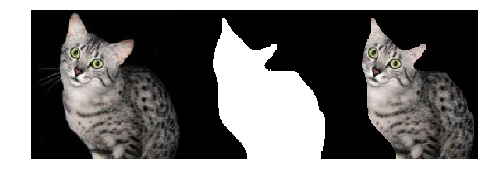

In [ ]:
# Google example
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

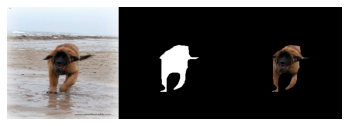

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
print(img.shape)    # (256, 256, 3)
img

(256, 256, 3)


array([[[0.97254902, 0.98823529, 0.99607843],
        [0.96862745, 0.98431373, 0.99215686],
        [0.96862745, 0.98431373, 0.99607843],
        ...,
        [0.97254902, 0.98823529, 1.        ],
        [0.97647059, 0.99215686, 1.        ],
        [0.97647059, 0.99215686, 1.        ]],

       [[0.96862745, 0.98431373, 0.99607843],
        [0.96470588, 0.98039216, 0.99215686],
        [0.96470588, 0.98039216, 0.99607843],
        ...,
        [0.96862745, 0.98431373, 0.99607843],
        [0.96862745, 0.98431373, 0.99607843],
        [0.97254902, 0.98823529, 1.        ]],

       [[0.96470588, 0.97647059, 0.99215686],
        [0.96078431, 0.97647059, 0.99215686],
        [0.96862745, 0.98431373, 0.99607843],
        ...,
        [0.96470588, 0.98039216, 0.99215686],
        [0.96862745, 0.98039216, 0.99215686],
        [0.97254902, 0.98823529, 0.99607843]],

       ...,

       [[0.91372549, 0.91372549, 0.91372549],
        [0.91372549, 0.91372549, 0.91372549],
        [0.91372549, 0

In [ ]:
print(msk.shape) # (256, 256, 3)
msk

(256, 256, 3)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
y[0].shape # (256, 256, 1)
y[0].squeeze().shape # (256, 256)
y[0].squeeze()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Single-image generator

In [ ]:
# single image generator

def image_generator(file, batch_size = 32, sz = (256, 256)):
  
  while True: 
       
    #variables for collecting batches of inputs and outputs 
    mask = None
    raw = None

    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0    # if bigger than 2, black out. 
        mask[mask != 0 ] = 1   # make the rest 1.
        
        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

    #preprocess a batch of images and masks 
    batch_x = np.array(mask)/255.
    batch_y = np.array(raw)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      

In [ ]:
x, y = next(image_generator("Abyssinian_201.jpg"))

plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

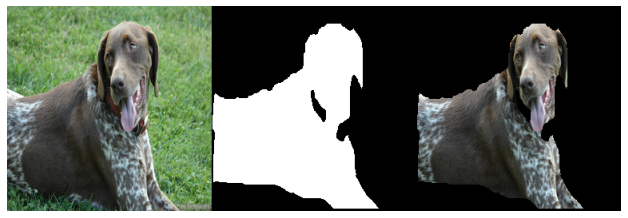

In [ ]:
batch_size = 32

# all image files in the 'images' folder
all_files = os.listdir('images')    # 7390 images
shuffle(all_files)

split = int(0.95 * len(all_files))  # 7020

#split into training and testing
train_files = all_files[0:split]    # 95% of all_files for train
test_files  = all_files[split:]     # 5% for test

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

x, y= next(train_generator)

plt.rcParams["figure.figsize"] = (11, 7)
plt.axis('off')

img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### Print batch of 32

In [ ]:
# all image files in the 'images' folder
all_files = os.listdir('images')    # 7390 images
shuffle(all_files)

split = int(0.95 * len(all_files))  # 7020

#split into training and testing
train_files = all_files[0:split]    # 95% of all_files for train
test_files  = all_files[split:]     # 5% for test

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

def batch_print(batch_size=10):
    x, y= next(train_generator)

    plt.rcParams["figure.figsize"] = (11, 7)
    plt.axis('off')

    img = x[0]
    msk = y[0].squeeze()
    msk = np.stack((msk,)*3, axis=-1)

    plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

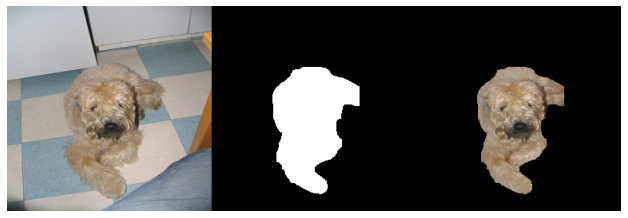

In [ ]:
for i in range(10):
    batch_print(32)

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

In [ ]:
train_steps = len(train_files) // batch_size
test_steps = len(test_files) // batch_size

model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,
                    validation_data = test_generator, 
                    validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30


TypeError: ignored

# Testing

In [116]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2021-10-31 17:24:26--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.226.115.34, 13.226.115.129, 13.226.115.120, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.226.115.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.02s   

2021-10-31 17:24:27 (3.74 MB/s) - ‘test.jpg’ saved [63219/63219]



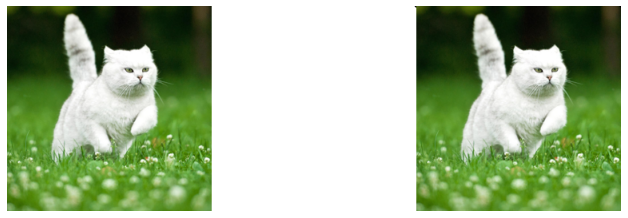

In [117]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

